In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

sns.set()

In [2]:
# 티커 리스트 정의
tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']

# EFT 객체 정의 및 OHLCV 가격 데이터 다운
etf = yf.Tickers(tickers) # 티커 객체 생성
data = etf.history(start='2015-01-01',actions=False) # ohlcv 가격 다운
data = data['Close'] # 종가 데이터만 남기기

[*********************100%%**********************]  9 of 9 completed


In [3]:
data.head(3)

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2015-01-02,40.771942,55.437874,16.930063,47.938206,36.769955,38.382542,35.621895,59.491104,64.595955
2015-01-05,39.732735,53.144512,16.574070,46.818443,36.208641,38.112633,35.186401,59.187721,63.360489
2015-01-06,39.380749,52.363781,16.320778,46.241577,35.772083,38.065006,35.208923,58.988346,62.729233


In [4]:
# 수익률 데이터
rets = data.pct_change().fillna(0)

# 연평균 기대 수익률 계산
er = rets.mean() * 252

# 공분산행렬 계산
cov = rets.cov() * 252

# 포트폴리오 시뮬레이션

In [5]:
# 포트폴리오 수익률 리스트 생성하기
p_returns = []

# 포트폴리오 변동성 리스트
p_volatility =[]

# 자산의 개수
noa = len(tickers)

# 시뮬레이션 횟수
n_ports = 10000


In [6]:
# 시뮬레이션 실행
for i in range(n_ports):
    # 난수 생성하여, 랜덤한 가중치 배분
    weights = np.random.random(noa) 
    weights /= np.sum(weights)
    
    # 포트폴리오 수익률과 변동성 계산
    ret = np.dot(weights, er)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov,weights)))
    
    # 시뮬레이션 통해 얻은 포트폴리오 수익률과 변동성 데이터 저장
    p_returns.append(ret)
    p_volatility.append(vol)

In [7]:
# 포트폴리오 수익률 및 변동성 데이터 배열로 변환
prets = np.array(p_returns)
pvols = np.array(p_volatility)

# 난수 생성을 통한 포트폴리오 시뮬레이션 시각화

- 산포도를 이용해 시뮬레이션 결과 시각화
- x축 : 포트폴리오 변동성
- y축 : 포트폴리오 수익률
- 색깔 : 포트폴리오 샤프 비율

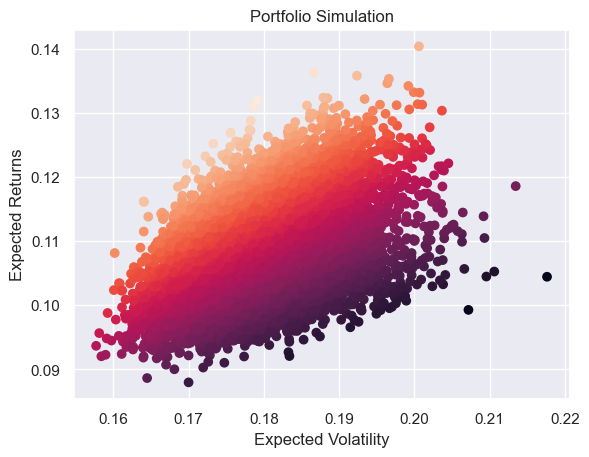

In [8]:
plt.scatter(x=pvols, y=prets, c=prets/pvols, marker='o')

plt.xlabel("Expected Volatility")
plt.ylabel("Expected Returns")
plt.title('Portfolio Simulation')

plt.show()

### 최적화 모듈 scipy.optimizer 사용

- scipy.optimize.minimize 문법 구조
    ```python
    scipy.optimize.minimize(
        fun: 목적함수
        x0: 초기값
        args: 초기값 외에 목적함수에 전달할 인자
        method: 최적화를 수행할 알고리즘의 종류
        bounds: 상하한 경계값
        constraints: 제약조건
        )
    ```

In [9]:
import scipy.optimize as sco

In [10]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(er * weights)
    pvol = np.sqrt(np.dot(weights.T, np.dot(cov,weights)))
    
    return np.array([pret, pvol, pret/pvol]) # 포트폴리오 수익률, 변동성, 샤프비율 반환

In [11]:
weights = np.random.random(noa)
weights /= np.sum(weights)

##### 목적함수 정의 : 포트폴리오 변동성

In [12]:
def obj_func(weights):
    return statistics(weights)[1]

##### 수익률 수준별 포트폴리오 최적화 수행

In [31]:
trets = np.linspace(0.07, 0.2, 50) # 타겟 return
tvols = [] # 타겟 return을 만족하는 결과값

In [32]:
for tret in trets:
    # 투가 가중치 초기값 = 동일가중
    init_guess = np.repeat(1/noa, noa)
    
    # 제약 조건(포트폴리오 목표 수익률, 현금 보유 비중 0)
    cons = ({'type':'eq','fun':lambda x: statistics(x)[0] - tret},
            {'type':'eq','fun':lambda x: np.sum(x) - 1})
    
    # 자산별 경계조건(숏 포지션 불가능)
    bnds = tuple((0.0, 1.0) for x in weights)
    
    # 최적화 알고리즘 수행
    res = sco.minimize(obj_func,
                       init_guess,
                       method='SLSQP',
                       bounds=bnds,
                       constraints=cons)
    
    # 최적화 알고리즘을 통해 찾아낸, 최적 포트폴리오의 변동성 값 저장
    tvols.append(res['fun'])

tvols = np.array(tvols)

##### 좌측 경계선 데이터 수집 및 시각화

In [33]:
# 좌측 경계선 데이터 수집
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

Text(0.5, 1.0, 'Efficient Frontier')

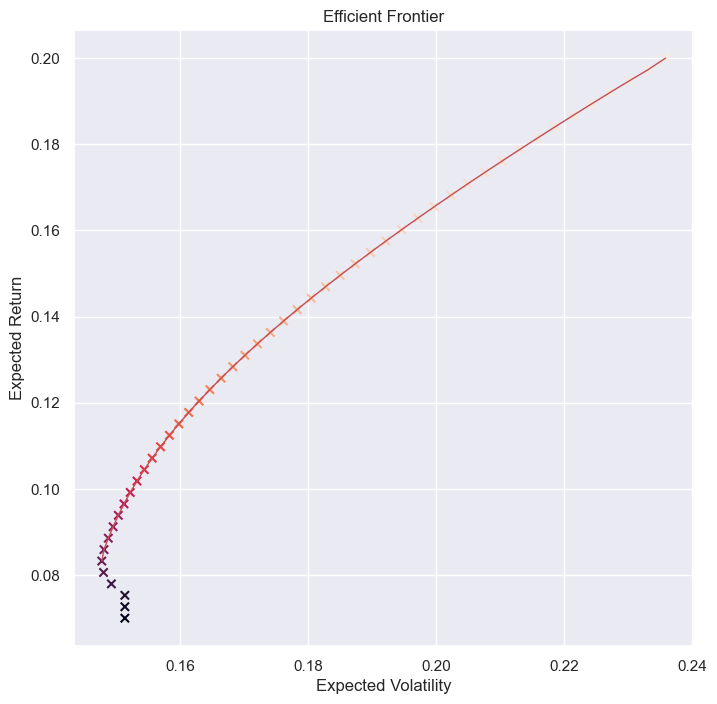

In [34]:
# 효율적 경계선 시각화
plt.figure(figsize=(8, 8))
plt.scatter(tvols, trets, c=trets/tvols, marker='x')
plt.plot(evols, erets, 'r', lw=1.0)
plt.grid(True)

plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')